# Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

# Prepare Generators and Variables Initialization

Found 3041 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


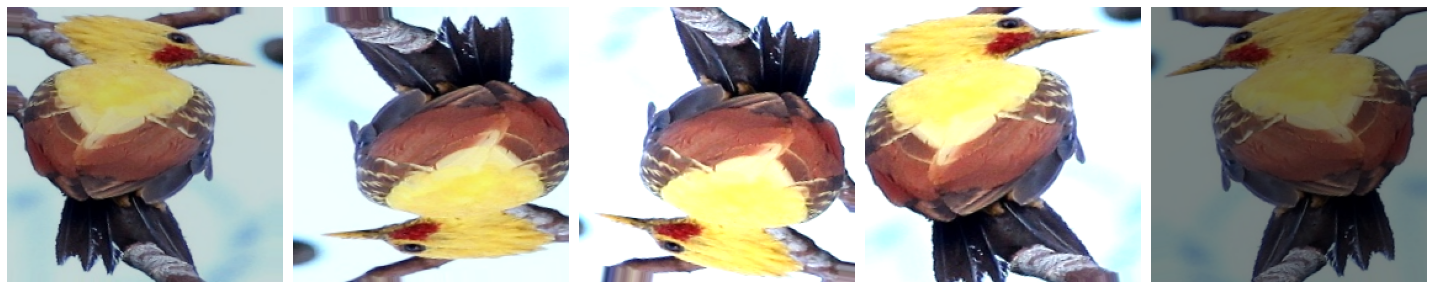

In [2]:
train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'
nr_birds = 20

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.5, 1.5],
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Split Data

In [ ]:

# Splitting the data starts here, we store the path to the training set into a variable for further referencing.

train_path = './dataset/20train'
test_path = './dataset/20test'
valid_path = './dataset/20valid'

birds = np.array(list(os.listdir(train_path)))
nr_birds = 20

idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

In [ ]:
# Function to store labels based on the folders.

def get_data_labels(path, birds, dimensions):
    data = []
    labels = []

    for bird in birds:
        imgs = [cv2.resize(cv2.imread(img), dimensions, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + bird + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[bird])
            
    return np.array(data), np.array(labels)

In [ ]:
data_train, labels_train = get_data_labels(train_path, idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels(test_path, idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels(valid_path, idx_to_name.values(), (224,224))

print(data_train.shape)

In [ ]:
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [ ]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

# Build model and train model

In [3]:
weights_path = "./dataset/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_vgg16 = VGG16(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

# Freezing the weights
for layer in base_vgg16.layers:
    layer.trainable = False

base_vgg16.summary();

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                   

2022-05-07 20:24:23.129385: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-07 20:24:23.129507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# use “get_layer” method to save the last layer of the network
last_layer = base_vgg16.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

x = Dropout(0.2)(x)

# add our new softmax layer with 3 hidden units
x = Dense(nr_birds, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_vgg16.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
new_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/Users/shaun/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

checkpointer = ModelCheckpoint(filepath='./checkpoints/birds.model.hdf5', save_best_only=True)

history = new_model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1, callbacks=[checkpointer, EarlyStoppingByLossVal(monitor='val_loss', value=0.01, verbose=1)])

Epoch 1/30


2022-05-07 20:24:31.612158: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-07 20:24:31.959765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 2.1996 - accuracy: 0.3920

2022-05-07 20:26:11.479379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 105s 2s/step - loss: 2.1996 - accuracy: 0.3920 - val_loss: 1.0814 - val_accuracy: 0.7100
Epoch 2/30
48/48 [==============================] - 196s 4s/step - loss: 1.1219 - accuracy: 0.6721 - val_loss: 0.5987 - val_accuracy: 0.8000
Epoch 3/30
48/48 [==============================] - 207s 4s/step - loss: 0.7419 - accuracy: 0.7780 - val_loss: 0.4611 - val_accuracy: 0.8600
Epoch 4/30
 1/48 [..............................] - ETA: 3:04 - loss: 0.6705 - accuracy: 0.7500

In [ ]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

# Testing 

In [ ]:
test_loss, test_acc = new_model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

In [ ]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [ ]:
# we use the validation data to verify the accuracy
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Valid Accuracy:", accuracy)

In [ ]:
# we use the test data to verify the accuracy
accuracy = get_accuracy(new_model, data_test, labels_test)
print("Test Accuracy:", accuracy)

In [ ]:
new_model.save('./models/cnn_model.h5')

## Running Predictions From Saved Model

In [ ]:
def decode (predicted_arr):
  train_path = './dataset/20train'

  all_birds_cat = np.array(list(os.listdir(train_path)))
  for i, pred in enumerate(predicted_arr):
    return all_birds_cat[np.argmax(pred)]


In [ ]:

model = load_model('./models/cnn_model.h5')

predict_image_path = './dataset/images to test/20.jpg'

plt.imshow(cv2.imread(predict_image_path))
plt.show();

img = load_img(predict_image_path, target_size=(224,224))
img = img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

predictions = model.predict(img)
label = decode(predictions)

print(label)

# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)